# Forecasting Bike Ride Data - Healthy Ride (Pittsburgh)

The following data set uses the Healthy Bike Ride dataset which can be found: https://data.wprdc.org/dataset?q=healthy+ride

There are two types of files in this repo - daily bike ride information, and station information. This workbook attempts to merge the two datasets together to obtain meaningful insights later on.

So far we have implemented ARIMA and XGBoost as a way to forecast general bike ridership throughout the year. We see that XGBoost performs better than ARIMA.

In [1]:
import os
from os.path import isfile, join
import re

import pandas as pd
from matplotlib import pyplot

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from pmdarima.arima import ADFTest, auto_arima



In [2]:
filelist = [f for f in os.listdir(os.getcwd()+"\\data") if isfile(join(os.getcwd()+"\\data", f))]
rentalfiles = [f for f in filelist if re.search(r'^rentals.*csv$' ,f)]

The daily bike ride information contains information around the start and stop time of each bike ride, and which station a bike exits from. 

In [3]:
parse_dates = ['Starttime', 'Stoptime']
df = pd.concat([pd.read_csv(os.getcwd() + "\\data\\"+f, parse_dates=parse_dates) for f in rentalfiles])
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.lower()
df['year'] = df['starttime'].dt.year
df['quarter'] = df['starttime'].dt.quarter
df.head(5)

,tripid,starttime,stoptime,bikeid,tripduration,fromstationid,fromstationname,tostationid,tostationname,usertype,year,quarter
0,33295341,2017-07-01 00:00:00,2017-07-01 00:06:00,70045,396,1045.0,S 27th St & Sidney St. (Southside Works),1048.0,S 18th St & Sidney St,Customer,2017,3
1,33295396,2017-07-01 00:05:00,2017-07-01 00:19:00,70274,850,1021.0,Taylor St & Liberty Ave,1024.0,S Negley Ave & Baum Blvd,Customer,2017,3
2,33295429,2017-07-01 00:10:00,2017-07-01 00:23:00,70249,819,1033.0,Ivy St & Walnut St,1029.0,Alder St & S Highland Ave,Customer,2017,3
3,33295436,2017-07-01 00:10:00,2017-07-01 00:23:00,70030,760,1033.0,Ivy St & Walnut St,1029.0,Alder St & S Highland Ave,Customer,2017,3
4,33295621,2017-07-01 00:35:00,2017-07-01 01:49:00,70009,4460,1008.0,Centre Ave & PPG Paints Arena,1008.0,Centre Ave & PPG Paints Arena,Customer,2017,3


Location files hold information around the station name, GPS coordinates, and the number of bike racks available at each station.

In [4]:
locationfiles = [f for f in filelist if re.search(r'locations.*csv$', f)]

df_loc = pd.concat([pd.read_csv(os.getcwd() + "\\data\\"+
                                locationfiles[i]).assign(year=re.split('_|\.', locationfiles[i])[1],
                                                                      quarter = re.split('_|\.', locationfiles[i])[2])
                   for i in range(0, len(locationfiles))])

df_loc = df_loc.rename(columns={'Station #' : 'station', 'Station Name': 'station_name', '# of Racks':'num_racks'})
df_loc = df_loc[-df_loc.station.isna()]


In [5]:
df_loc = df_loc[['station', 'station_name', 'num_racks', 'Latitude', 'Longitude', 'year', 'quarter']]
df_loc['quarter'] = df_loc['quarter'].str[-1].astype(int)
df_loc['year'] = df_loc['year'].astype(int)
df_loc.head(5)

,station,station_name,num_racks,Latitude,Longitude,year,quarter
0,1000.0,Liberty Ave & Stanwix St,16.0,40.441326,-80.004679,2017,3
1,1001.0,Forbes Ave & Market Square,19.0,40.440877,-80.003080,2017,3
2,1002.0,Third Ave & Wood St,15.0,40.439030,-80.001860,2017,3
3,1003.0,First Ave & Smithfield St (Art Institute),15.0,40.437200,-80.000375,2017,3
4,1004.0,First Ave & B St (T Station),15.0,40.435887,-79.997102,2017,3


## Data Cleaning and Checks

One interesting thing to ask of the data set is to see if the number of racks at each station is constant over time. A quick aggregation shows that the answer to the question is no.

In [6]:
df_hold = df_loc[['station', 
        'station_name', 
        'Latitude', 
        'Longitude', 
        'num_racks']].groupby(['station', 
                               'station_name', 
                               'Latitude', 
                               'Longitude']).agg({'num_racks' : ['min', 'max']}).reset_index()

df_hold['eq'] = (df_hold[('num_racks', 'min')] == df_hold[('num_racks', 'max')])
df_hold[df_hold['eq'] == False]

station                                 station_name   Latitude  Longitude  \
                                                                                
5   1005.0                        Forbes Ave & Grant St  40.438882 -79.997592   
6   1006.0  Ross St & Sixth Ave (Steel Plaza T Station)  40.440193 -79.995084   
7   1007.0                    Stevenson St & Forbes Ave  40.437643 -79.986695   
8   1008.0                Centre Ave & PPG Paints Arena  40.440368 -79.988636   
12  1012.0       North Shore Trail & Ft Duquesne Bridge  40.445834 -80.008882   
22  1020.0     42nd St & Penn Ave (Children's Hospital)  40.465893 -79.954417   
25  1023.0                      Liberty Ave & Baum Blvd  40.456505 -79.939362   
30  1028.0         Penn Ave & Putnam St (Bakery Square)  40.455821 -79.915248   
37  1035.0                   Fifth Ave & S Dithridge St  40.446744 -79.950881   
41  1039.0                            Atwood St & Bates  40.437987 -79.953670   
54  1050.0                             Healthy Ride Hub  40.461817 -79.968002   
63  1061.0                         33rd St and Penn Ave  40.462026 -79.968114   

   num_racks           eq  
         min   max         
5       13.0  19.0  False  
6        7.0  21.0  False  
7       15.0  19.0  False  
8        5.0  35.0  False  
12      31.0  35.0  False  
22       8.0  15.0  False  
25      15.0  19.0  False  
30       8.0  19.0  False  
37       8.0  19.0  False  
41       8.0  19.0  False  
54       0.0   2.0  False  
63       2.0   6.0  False

Additionally, from the above aggregation we note that the number of available racks for station number 1050 is dubious, so we are going to replace that with 2. First check that this happens for station number 1050, and then we will replace accordingly.

In [7]:
df_loc[df_loc['num_racks'] == 0]

,station,station_name,num_racks,Latitude,Longitude,year,quarter
50,1050.0,Healthy Ride Hub,0.0,40.461817,-79.968002,2018,1
50,1050.0,Healthy Ride Hub,0.0,40.461817,-79.968002,2018,2
50,1050.0,Healthy Ride Hub,0.0,40.461817,-79.968002,2018,3
50,1050.0,Healthy Ride Hub,0.0,40.461817,-79.968002,2018,4
50,1050.0,Healthy Ride Hub,0.0,40.461817,-79.968002,2019,1
50,1050.0,Healthy Ride Hub,0.0,40.461817,-79.968002,2019,2


In [8]:
df_loc['num_racks'] = df_loc['num_racks'].apply(lambda x : x if x > 0 else 2)

### Handling NULL information

Now turning our attention to the bike ridership dataset, we note that sometimes bikes take journeys and do not get immediately reracked at a station. Below we see three consecutive trips for Bike 70604 moving from station Arch St & Jacksonia St to NULL station id. The second trip has no station information, and for the third trip the bike does not start at any particular station but ends up back at Arch St & Jacksonia St.

We also note that the start and stop times for these three rides are fairly close together. This leads us to believe that these trips were taken by the same person, and should thus be considered as a single trip.

In [9]:
df[['tripid', 'bikeid', 'starttime', 
    'stoptime', 'fromstationid', 'fromstationname',
   'tostationid', 'tostationname']][(df.bikeid == 70604) & (df.year == 2020) & (df.quarter == 4) & 
       (df.tripid>=107796326) & (df.tripid<108005204)]

,tripid,bikeid,starttime,stoptime,fromstationid,fromstationname,tostationid,tostationname
3108,107999252,70604,2020-10-10 10:18:00,2020-10-10 10:31:00,49881.0,Arch St & Jacksonia St,NaN,BIKE 70604
3125,108001051,70604,2020-10-10 10:42:00,2020-10-10 10:53:00,NaN,BIKE 70604,NaN,BIKE 70604
3148,108003271,70604,2020-10-10 11:09:00,2020-10-10 11:13:00,NaN,BIKE 70604,49881.0,Arch St & Jacksonia St


To account for this we shall make the appropriate refinements to the datasets to capture the above view of a single bike ride.

In [10]:
df['stoptime_adj'] = df.apply( lambda x : x['stoptime'] if x['tostationid'] > 0  
                                      else x['tostationid'] , axis=1)

df['tostationid_adj'] = df['tostationid']
df = df.sort_values(['bikeid', 'starttime']).reset_index(drop=True)
df['tostationid_adj'] = df['tostationid_adj'].fillna(method='bfill')
df['stoptime_adj'] = df['stoptime_adj'].fillna(method='bfill')

df[['tripid', 'bikeid', 'starttime', 
    'stoptime', 'fromstationid', 'fromstationname',
   'tostationid', 'tostationname', 
    'stoptime_adj', 'tostationid_adj']][(df.bikeid == 70604) & (df.year == 2020) & (df.quarter == 4) & 
       (df.tripid>=107796326) & (df.tripid<108005204)]

,tripid,bikeid,starttime,stoptime,fromstationid,fromstationname,tostationid,tostationname,stoptime_adj,tostationid_adj
280262,107999252,70604,2020-10-10 10:18:00,2020-10-10 10:31:00,49881.0,Arch St & Jacksonia St,NaN,BIKE 70604,2020-10-10 11:13:00,49881.0
280263,108001051,70604,2020-10-10 10:42:00,2020-10-10 10:53:00,NaN,BIKE 70604,NaN,BIKE 70604,2020-10-10 11:13:00,49881.0
280264,108003271,70604,2020-10-10 11:09:00,2020-10-10 11:13:00,NaN,BIKE 70604,49881.0,Arch St & Jacksonia St,2020-10-10 11:13:00,49881.0


Now we are ready to merge the datasets, which will then be used for forecasting.

In [11]:
df = df.merge(df_loc[['station', 'num_racks', 
                      'year', 'quarter', 'Latitude', 'Longitude']], how='left', left_on=['year', 'quarter', 'fromstationid'], 
                                      right_on=['year', 'quarter', 'station'])
df = df.rename(columns={'num_racks' : 'from_tot_racks', 'Latitude' : 'from_lat', 'Longitude' : 'from_long'})


df = df.merge(df_loc[['station', 'num_racks', 
                      'year', 'quarter', 'Latitude', 'Longitude']], how='left', left_on=['year', 'quarter', 'tostationid_adj'], 
                                      right_on=['year', 'quarter', 'station'])

df = df.rename(columns={'num_racks' : 'to_tot_racks', 
                       'Latitude' : 'to_lat', 'Longitude' : 'to_long'})

df = df[['tripid', 'starttime', 'stoptime', 'stoptime_adj', 'bikeid', 'tripduration',
       'fromstationid', 'fromstationname', 'tostationid', 'tostationid_adj', 'tostationname',
       'usertype', 'year', 'quarter', 'from_tot_racks', 'to_tot_racks', 'from_lat', 'from_long',
        'to_lat', 'to_long']]

In [12]:
df_filt = df[(-df['from_tot_racks'].isna()) & (-df['tostationid'].isna()) ] 
df_filt['starttime_date'] = df_filt['starttime'].dt.date
df_filt.head(5)

C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tripid,starttime,stoptime,stoptime_adj,bikeid,tripduration,fromstationid,fromstationname,tostationid,tostationid_adj,...,usertype,year,quarter,from_tot_racks,to_tot_racks,from_lat,from_long,to_lat,to_long,starttime_date
2,33337058,2017-07-01 12:55:00,2017-07-01 13:14:00,2017-07-01 13:14:00,70000,1164,1041.0,Fifth Ave & S Bouquet St,1049.0,1049.0,...,Customer,2017,3,19.0,19.0,40.442325,-79.957604,40.428661,-79.986358,2017-07-01
3,33406113,2017-07-02 17:33:00,2017-07-02 18:28:00,2017-07-02 18:28:00,70000,3277,1049.0,S 12th St & E Carson St,1049.0,1049.0,...,Customer,2017,3,19.0,19.0,40.428661,-79.986358,40.428661,-79.986358,2017-07-02
4,33431751,2017-07-03 07:28:00,2017-07-03 07:36:00,2017-07-03 07:36:00,70000,513,1049.0,S 12th St & E Carson St,1006.0,1006.0,...,Subscriber,2017,3,19.0,21.0,40.428661,-79.986358,40.440193,-79.995084,2017-07-03
5,33481665,2017-07-03 15:37:00,2017-07-03 16:51:00,2017-07-03 16:51:00,70000,4409,1006.0,Ross St & Sixth Ave (Steel Plaza T Station),1006.0,1006.0,...,Customer,2017,3,21.0,21.0,40.440193,-79.995084,40.440193,-79.995084,2017-07-03
6,33625477,2017-07-05 16:49:00,2017-07-05 17:18:00,2017-07-05 17:18:00,70000,1768,1006.0,Ross St & Sixth Ave (Steel Plaza T Station),1048.0,1048.0,...,Subscriber,2017,3,21.0,16.0,40.440193,-79.995084,40.429338,-79.980684,2017-07-05


First let's do a visual inspection to see if there are differences between types of bike users.

<AxesSubplot:xlabel='starttime_date'>

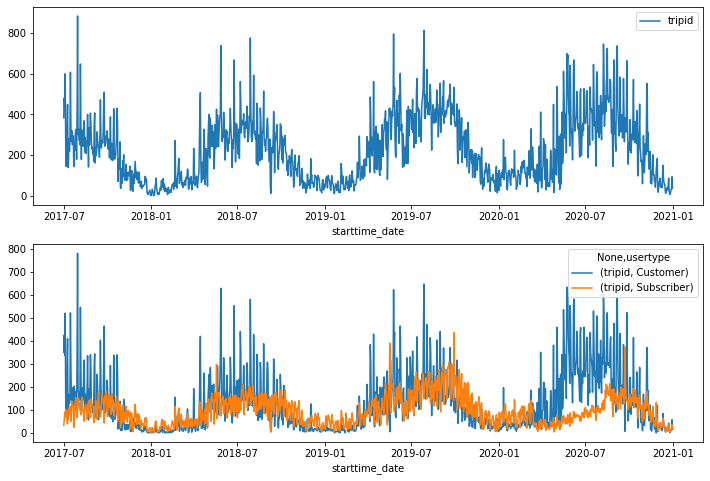

In [13]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
df_filt[['starttime_date', 'tripid']].groupby('starttime_date').count().plot(ax=ax1)
ax2 = fig.add_subplot(212)
df_filt[['starttime_date', 'usertype', 'tripid']].groupby(['starttime_date', 'usertype']).count().unstack(1).plot(ax=ax2)

It seems that there is more variability with one-off Customers compared to Subscribers. But since the seasonality is similar, we will attempt to forecast on the entire dataset.

Now we split the data into a training set and a test set.

In [14]:
srs = df_filt[['starttime_date', 'tripid']].groupby('starttime_date').count()
srs = srs.reset_index()
test_size = 90
srs_train = srs[:-test_size]
srs_holdout = srs[-test_size:]


## Implement ARIMA 

In [15]:
from statsmodels.tsa.stattools import adfuller
X = srs_train.tripid
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Insufficient evidence to reject null hypothesis. Let's try d=1 max.

ADF Statistic: -1.862305
p-value: 0.349996
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


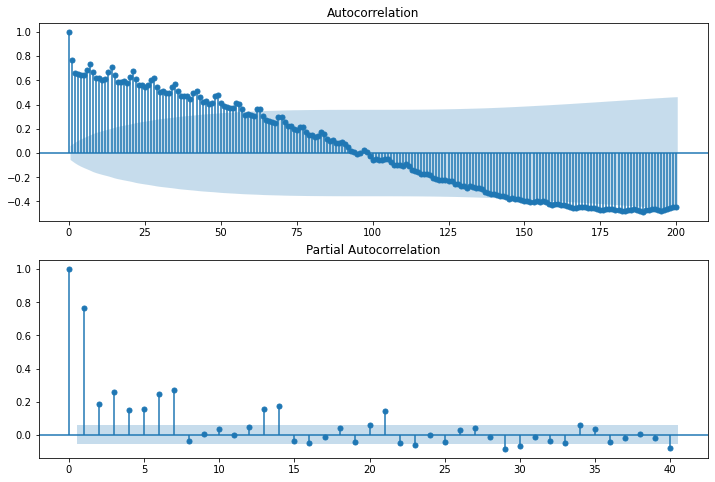

In [16]:
import statsmodels.api as sm

fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(srs_train.tripid, lags=200, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(srs_train.tripid, lags=40, ax=ax2)

In [17]:
autoarima_model = auto_arima(X, start_p = 0, d=1, start_q = 0,
                           max_p = 20, max_d = 2, max_q = 20,
                            start_P = 2, D=1, start_Q = 2,
                             max_P = 20, max_D = 10, max_Q = 20,
                             max_order = 20,
                           m = 7, seasonal = True,
                           error_action = 'warn', trace = True,
                           suppress_warnings = True,
                           stepwise = True,
                           random_state = 20, n_fits = 200)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=14238.045, Time=1.54 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=14840.833, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=14363.546, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=13873.994, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=13873.340, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=14173.337, Time=0.32 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=13875.332, Time=1.09 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=13875.338, Time=1.20 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=13873.385, Time=1.02 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=14017.712, Time=0.66 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=13874.118, Time=4.01 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=14237.766, Time=0.35 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=13823.419, Time=1.34 sec
 ARIMA(1,1,1)(0,1,1)[7]  

In [18]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1183
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -6906.719
Date:                           Fri, 02 Apr 2021   AIC                          13821.438
Time:                                   10:58:30   BIC                          13841.714
Sample:                                        0   HQIC                         13829.083
                                          - 1183                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2667      0.027     10.012      0.000       0.215       0.319
ma.L1         -0.8991      0.015    -61.667      0.000      -0.928      -0.871
ma.S.L7       -0.8414      0.013    -64.723      0.000      -0.867      -0.816
sigma2      7400.0900    187.378     39.493      0.000    7032.837    7767.343
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               620.08
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.37
Prob(H) (two-sided):                  0.33   Kurtosis:                         6.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

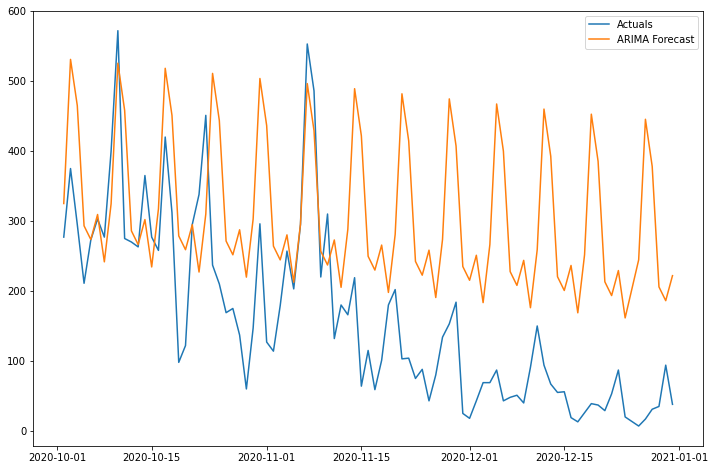

In [19]:
x_pred = autoarima_model.predict(test_size)

fig = pyplot.figure(figsize=(12,8))

pyplot.plot(srs_holdout['starttime_date'], srs_holdout['tripid'], label ='Actuals')
pyplot.plot(srs_holdout['starttime_date'], x_pred, label = 'ARIMA Forecast')
pyplot.legend()

In [20]:
import numpy as np
mape = 1/test_size * np.sum(np.abs((srs_holdout['tripid'] - x_pred ) / srs_holdout['tripid']))
print("MAPE Error: ", mape)

MAPE Error:  3.0842426850376654


## Implement XGBoost Time Series with Hyperopt

In [21]:
import xgboost as xgb

from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, hp, fmin, Trials, STATUS_OK, STATUS_FAIL
from functools import partial
from hyperopt.pyll import scope

In [22]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
   # df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [23]:
srs_train['date'] = pd.to_datetime(srs_train['starttime_date'])
x_train, y_train = create_features(srs_train, label='tripid')

srs_holdout['date'] = pd.to_datetime(srs_holdout['starttime_date'])
x_test, y_test = create_features(srs_holdout, label='tripid')

C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [24]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

space ={
    'eval_metric' : 'rmse',
    'objective'   : 'reg:squarederror',
    #'max_depth'   : hp.choice("max_depth", np.arange(2, 7, dtype=int)),   # something wrong with hyperopt and maxdepth  
                                                                            # will use default value for now
    'alpha'       : hp.uniform('alpha', 1e-6, 1e-4 ),
    'lambda'      : hp.uniform('lambda', 1e-6, 1e-4 ),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'learning_rate': hp.quniform("learning_rate", 0.001, 0.5, 0.01),
    'eta': hp.quniform('eta', 0.025, 0.5, 0.025),  
    'seed'             : hp.randint('seed',2000000)
   }
    

In [25]:
def objective(space,
            xgb_train = dtrain,
            tcsv = TimeSeriesSplit(n_splits = 3)):
    
    xgb_params = sample(space)
    mdl = xgb.cv(
                        xgb_params,
                        xgb_train,
                        num_boost_round = 750,##change to 750,
                        folds = tcsv
                       
                        )
    
    return{'loss' : mdl['test-rmse-mean'].min(), 'status' : STATUS_OK}

In [26]:
trials = Trials()
best_params = fmin(fn=objective,
                     space=space,
                     algo=tpe.suggest,
                     max_evals=100,
                     trials=trials,
                     verbose=0)
print(best_params)

{'alpha': 3.561383538529097e-05, 'eta': 0.125, 'gamma': 1.0, 'lambda': 5.9406290352885717e-05, 'learning_rate': 0.37, 'seed': 55661}


In [27]:
model = xgb.train(best_params, dtrain)
xgb_pred = model.predict(dtest)

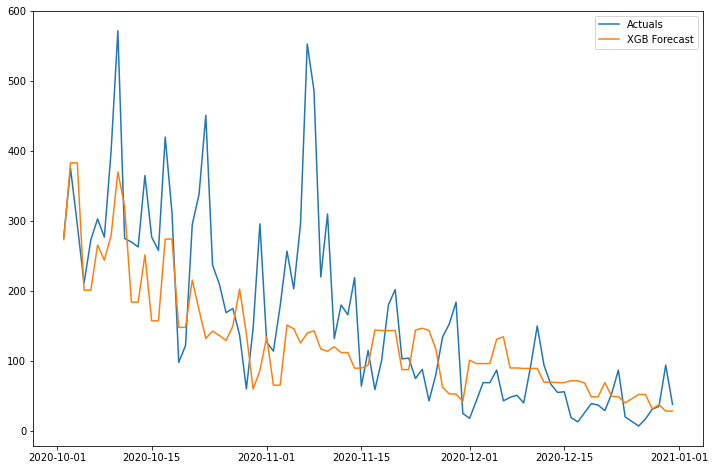

In [28]:
fig = pyplot.figure(figsize=(12,8))
pyplot.plot(srs_holdout['starttime_date'], srs_holdout['tripid'], label = 'Actuals')
pyplot.plot(srs_holdout['starttime_date'], xgb_pred, label = 'XGB Forecast')
pyplot.legend()

In [29]:
mape = 1/test_size * np.sum(np.abs((srs_holdout['tripid'] - xgb_pred ) / srs_holdout['tripid']))
print("MAPE Error: ", mape)

MAPE Error:  0.6908268476132706


### Comparing Decay in Error

In [30]:
srs_holdout['forecast_xgb'] = xgb_pred
srs_holdout['forecast_arima'] = x_pred
srs_holdout['forecast_lead'] = [x for x in range(0, len(srs_holdout))]

srs_holdout['difference_xgb'] = np.abs(srs_holdout['tripid'] - srs_holdout['forecast_xgb']) / srs_holdout['tripid']
srs_holdout['difference_arima'] = np.abs(srs_holdout['tripid'] - srs_holdout['forecast_arima']) / srs_holdout['tripid']

srs_holdout['mape_xgb'] = srs_holdout['difference_xgb'].cumsum() / srs_holdout['forecast_lead']
srs_holdout['mape_arima'] = srs_holdout['difference_arima'].cumsum() / srs_holdout['forecast_lead']

C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\adelynyeoh\Anaconda3\envs\working_python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


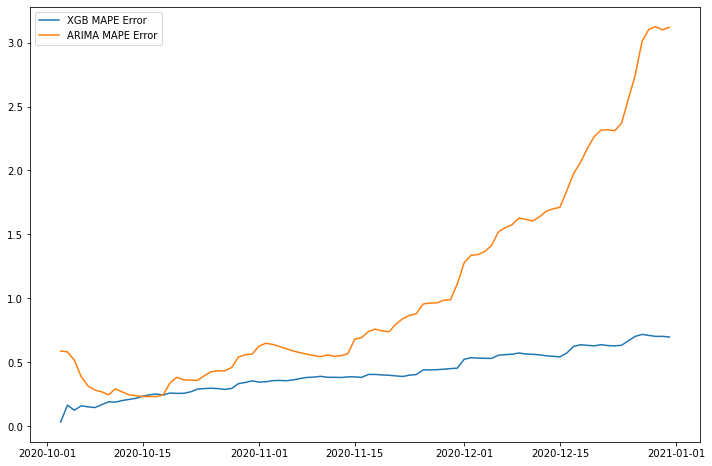

In [31]:
fig = pyplot.figure(figsize=(12,8))

pyplot.plot(srs_holdout['starttime_date'], srs_holdout['mape_xgb'], label = 'XGB MAPE Error')
pyplot.plot(srs_holdout['starttime_date'], srs_holdout['mape_arima'], label = 'ARIMA MAPE Error')
pyplot.legend()

### Forecasting For Each Station

In [32]:
srs_stat = df_filt[['starttime_date', 'fromstationid', 'tripid']].groupby(['starttime_date', 'fromstationid']).count()
srs_stat = srs_stat.reset_index()
test_size = 90
srs_stat_train = srs_stat[:-test_size]
srs_stat_holdout = srs_stat[-test_size:]

Number of Stations:  114


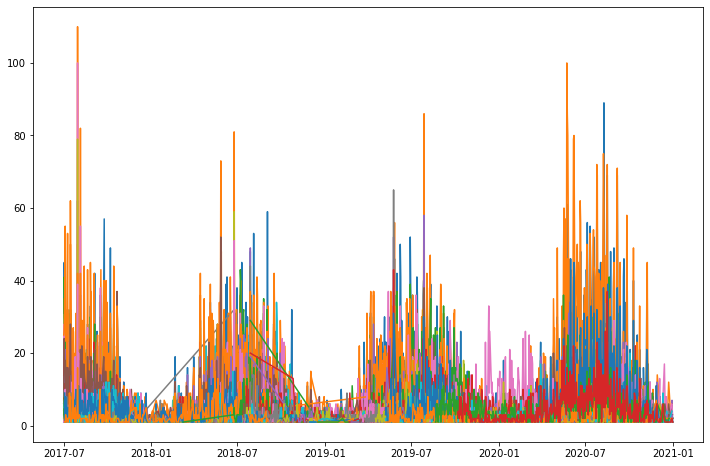

In [33]:
stations = srs_stat['fromstationid'].unique()
print("Number of Stations: ", len(stations))

fig = pyplot.figure(figsize=(12,8))
for i in range(0, len(stations)):
    pyplot.plot(srs_stat[srs_stat['fromstationid'] == stations[i]]['starttime_date'], 
            srs_stat[srs_stat['fromstationid'] == stations[i]]['tripid'])

Trend seems similar to the general ridership anyway. Forecasting on the overall dataset seems sufficient.